<a name="5"></a>
## Movie recommendations <img align="left" src="film_man_action.png" style=" width:40px;  " >

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(dpi=100) # To increase the resolution of the plots
np.random.seed(42)

<Figure size 640x480 with 0 Axes>

In [2]:
df = pd.read_csv('movies.csv')
df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [3]:
# @title loading my U, V, f, b_u and b_i

import pickle
import gzip

with gzip.open('data_structure/k_20/U_k20.pkl.gz', 'rb') as file:
    U = pickle.load(file)
with gzip.open('data_structure/k_20/V_k20.pkl.gz', 'rb') as file:
    V = pickle.load(file)
with gzip.open('data_structure/k_20/f_k20.pkl.gz', 'rb') as file:
    f = pickle.load(file)
with gzip.open('data_structure/k_20/b_u_k20.pkl.gz', 'rb') as file:
    b_u = pickle.load(file)
with gzip.open('data_structure/k_20/b_i_k20.pkl.gz', 'rb') as file:
    b_i = pickle.load(file)
    
    
# loading my mappings & structured data
with gzip.open('data_structure/genres.pkl.gz', 'rb') as file:
    genres = pickle.load(file)
with gzip.open('data_structure/user_2_id.pkl.gz', 'rb') as file:
    user_2_id = pickle.load(file)
with gzip.open('data_structure/id_2_user.pkl.gz', 'rb') as file:
    id_2_user = pickle.load(file)
with gzip.open('data_structure/movie_2_id.pkl.gz', 'rb') as file:
    movie_2_id = pickle.load(file)
with gzip.open('data_structure/id_2_movie_genres.pkl.gz', 'rb') as file:
    id_2_movie_genres = pickle.load(file)
with gzip.open('data_structure/user_2_data.pkl.gz', 'rb') as file:
    user_2_data = pickle.load(file)
with gzip.open('data_structure/movie_2_data.pkl.gz', 'rb') as file:
    movie_2_data = pickle.load(file)

In [5]:
num_movies = len(movie_2_data) # Number of movies

In [6]:
# @title Saved Hyper-parameters
lambda_ = 1e-2 
tau = 0.1 
gamma = 0.1 
k = 20 

mu = 3.5271
sigma = 1.0598

In [7]:
# @title Useful functions

def predict_rating(b_u,b_i,u,v):
    '''predict the rating that the user of params u, b_u would give to the movie of params v, b_v.'''
    return mu + sigma*(b_u + b_i + np.dot(u,v))

def train_user_params(user_ratings):
    '''
    Args
        user_ratings: A 1D numpy array of size the number of movies,
                      containing all the ratings of the user at the position
                      of the movies he has rated, and zero elsewhere.
    returns:
        b: user bias (scalar);
        u: user embbeding vector.
    '''
    # parameters initialization
    b = 0
    u = np.random.multivariate_normal(np.zeros(k), np.eye(k)/np.sqrt(k), size=1).T
    
    movie_indices = [i for i in range(len(user_ratings)) if user_ratings[i] > 0]
    ratings = user_ratings[movie_indices] 
    size = len(ratings)
    rates = (ratings - mu) / sigma  # Normalisation of ratings
    
    while True:
        b_prev = b
        u_prev = u
        # Update user bias b 
        UtV = u.T @ V[:,movie_indices]
        b_items = b_i[movie_indices]
        b = lambda_*np.sum(rates-UtV-b_items)/(lambda_*size+gamma)
        # Update user latent factor u
        vectors = V[:,movie_indices] * (rates-b-b_items)
        vector = lambda_ * vectors.sum(axis=1)
        matrix = np.sum([V[:,index].reshape(-1,1) @ V[:,index].reshape(-1,1).T for index in movie_indices], axis=0)
        matrix = np.linalg.inv(lambda_*matrix + tau*np.eye(k))
        u = matrix @ vector

        if np.linalg.norm(u - u_prev) < 1e-20 and abs(b - b_prev) < 1e-20:
            break
            
    return b, u

In the cell below, you can enter your own movie choices. The algorithm will then make recommendations for you! We have filled out some values according to our preferences, but after you have things working with our choices, you should change this to match your tastes.
A list of all movies in the dataset is in the file **movies.csv**.

In [8]:
my_ratings = np.zeros(num_movies) #  Initialize my ratings

def my_rating(movieId, rating):
    '''Gives the rating rating to the movie of ID movieId'''
    index = movie_2_id[movieId]
    my_ratings[index] = rating

# Check the file movies.csv for id of each movie in our dataset
# For example, 'Lord of the Rings: The Fellowship of the Ring, The (2001)' has ID 4993, so to rate it "5", you can set
my_rating(4993, 5) 

#Or suppose you did not enjoy 'Window of the Soul (2001)', you can set
my_rating(209159, 0.5);

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
# my_rating(4306, 5)   # Shrek (2001)
# my_rating(5816, 5)   # Harry Potter and the Chamber of Secrets (2002)
# my_rating(7361, 3)   # Eternal Sunshine of the Spotless Mind (2004)
# my_rating(86668, 1)   # Louis Theroux: Law & Disorder (2008)
# my_rating(6539, 5)   # Pirates of the Caribbean: The Curse of the Black Pearl (2003)

my_rated = [i for i in range(len(my_ratings)) if my_ratings[i] > 0]

print('\nNew user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print(f"Rated {my_ratings[i]} for  {df.loc[df['movieId'] == id_2_movie_genres[i][0], 'title'].iloc[0]}");


New user ratings:

Rated 5.0 for  Lord of the Rings: The Fellowship of the Ring, The (2001)
Rated 0.5 for  Window of the Soul (2001)


In [9]:
# Let's learn the embbeding vector u and the bias b of that new user
b, u = train_user_params(my_ratings)

In [10]:
b

-0.23001614211496393

In [11]:
u

array([ 0.01311801, -0.02732914, -0.06646442,  0.06429619,  0.06581618,
        0.08822889, -0.03052292,  0.08771727, -0.08755369,  0.04388306,
       -0.00348292, -0.05958023, -0.0124015 , -0.0637658 ,  0.04730898,
        0.0273131 , -0.04213569, -0.0783352 ,  0.07765503, -0.00840867])

## Recommendations
Below, we compute the ratings for all the movies and users and display the movies that are recommended. These are based on the movies and ratings entered as `my_ratings[]` above. To predict the rating of movie $i$ for our user, we use the function `predict_rating()` defined above.

In [12]:
# List of tuples (i,r) sorted in the descending order of the ratings r
my_predictions = sorted(enumerate([predict_rating(b, b_i[n], u, V[:,n]) for n in range(num_movies)]), reverse=True, key=lambda t: t[1])

In [13]:
# The top 20 recommendations
for num, t in enumerate(my_predictions[:20]):
    i = t[0]
    print(f"{num}: {df.loc[df['movieId'] == id_2_movie_genres[i][0], 'title'].iloc[0]}")

0: Lord of the Rings: The Return of the King, The (2003)
1: Lord of the Rings: The Fellowship of the Ring, The (2001)
2: Lord of the Rings: The Two Towers, The (2002)
3: Pirates of the Caribbean: The Curse of the Black Pearl (2003)
4: Hobbit: An Unexpected Journey, The (2012)
5: Hobbit: The Desolation of Smaug, The (2013)
6: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
7: Band of Brothers (2001)
8: Princess Bride, The (1987)
9: Braveheart (1995)
10: The Hobbit: The Battle of the Five Armies (2014)
11: The Lost Room (2006)
12: Usual Suspects, The (1995)
13: Gladiator (2000)
14: Planet Earth (2006)
15: Indiana Jones and the Last Crusade (1989)
16: Inception (2010)
17: Pirates of the Caribbean: Dead Man's Chest (2006)
18: Bill Burr: Why Do I Do This? (2008)
19: Sixth Sense, The (1999)


## Most polarizing movies

In [14]:
# List of tuples (i,v) sorted in the descending order of the normes of v
po_movies = sorted(enumerate([np.linalg.norm(V[:,n]) for n in range(num_movies)]), reverse=True, key=lambda t: t[1])

In [16]:
# The top 15 most polarizing movies
indices = []
for num, t in enumerate(po_movies[:15]):
    i = t[0]
    print(f"{num}: {df.loc[df['movieId'] == id_2_movie_genres[i][0], 'title'].iloc[0]} ||| norm_of_embedding:{t[1]:.2f}")
    indices.append(i)

0: Lord of the Rings: The Return of the King, The (2003) ||| norm_of_embedding:9.58
1: Lord of the Rings: The Fellowship of the Ring, The (2001) ||| norm_of_embedding:9.45
2: Lord of the Rings: The Two Towers, The (2002) ||| norm_of_embedding:9.45
3: Dumb & Dumber (Dumb and Dumber) (1994) ||| norm_of_embedding:8.55
4: Kill Bill: Vol. 1 (2003) ||| norm_of_embedding:8.55
5: Kill Bill: Vol. 2 (2004) ||| norm_of_embedding:8.32
6: Natural Born Killers (1994) ||| norm_of_embedding:8.18
7: Ace Ventura: Pet Detective (1994) ||| norm_of_embedding:8.05
8: Star Wars: Episode IV - A New Hope (1977) ||| norm_of_embedding:8.00
9: Star Wars: Episode I - The Phantom Menace (1999) ||| norm_of_embedding:7.82
10: Star Wars: Episode V - The Empire Strikes Back (1980) ||| norm_of_embedding:7.78
11: Star Wars: Episode II - Attack of the Clones (2002) ||| norm_of_embedding:7.77
12: Star Wars: Episode III - Revenge of the Sith (2005) ||| norm_of_embedding:7.74
13: Star Wars: Episode VI - Return of the Jedi (1

## Embbedings in 2D

In [17]:
# @title loading my U, V, f, b_u and b_i in 2D

import pickle
import gzip

with gzip.open('data_structure/k_2/U_k2.pkl.gz', 'rb') as file:
    U2 = pickle.load(file)
with gzip.open('data_structure/k_2/V_k2.pkl.gz', 'rb') as file:
    V2 = pickle.load(file)
with gzip.open('data_structure/k_2/f_k2.pkl.gz', 'rb') as file:
    f2 = pickle.load(file)
with gzip.open('data_structure/k_2/b_u_k2.pkl.gz', 'rb') as file:
    b_u2 = pickle.load(file)
with gzip.open('data_structure/k_2/b_i_k2.pkl.gz', 'rb') as file:
    b_i2 = pickle.load(file)

#### Plotting the 15 most polarizing movies

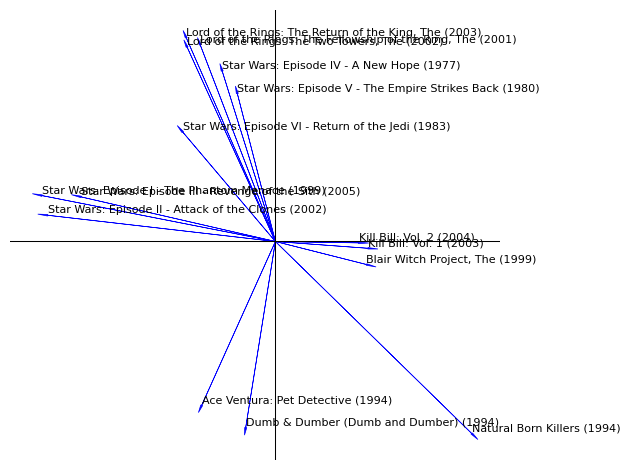

In [19]:
indices = np.array(indices)
v = V2[:,indices]
vectors = [[0, 0, v[0,i], v[1,i], df.loc[df['movieId']== id_2_movie_genres[indices[i]][0], 'title'].iloc[0]] for i in range(len(indices))]
# Plot each vector and label
for vector in vectors:
    x_origin, y_origin, x_direction, y_direction, label = vector
    plt.arrow(float(x_origin), float(y_origin), float(x_direction), float(y_direction),
              head_width=0.02, head_length=0.1, fc='blue', ec='blue', lw=0.5)
    plt.text(float(x_origin) + float(x_direction), float(y_origin) + float(y_direction), label, fontsize=8, ha='left', va='bottom')   
plt.axhline(0, color='black', lw=0.75)
plt.axvline(0, color='black', lw=0.75)
# Remove x and y axes along with labels and numbers
plt.axis('off')
# Show plot
plt.tight_layout()
plt.savefig('The_15_most_polarizing_movies.pdf')
plt.show()

#### Feature genre embbedings

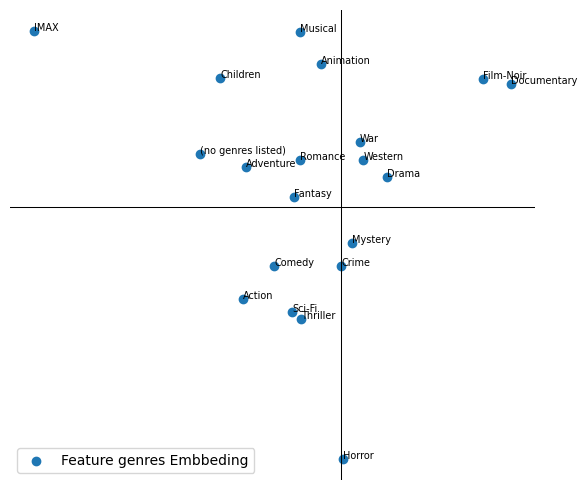

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.axhline(0, color='black', lw=0.75)
ax.axvline(0, color='black', lw=0.75)
ax.scatter(f2[0], f2[1], label = 'Feature genres Embbeding')
for i, (x, y) in enumerate(zip(f2[0], f2[1])):
    ax.text(x, y, genres[i], fontsize=7)
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.savefig('feature_genre_embeddings.pdf')
plt.show()

#### Movies embbeding taged by genres

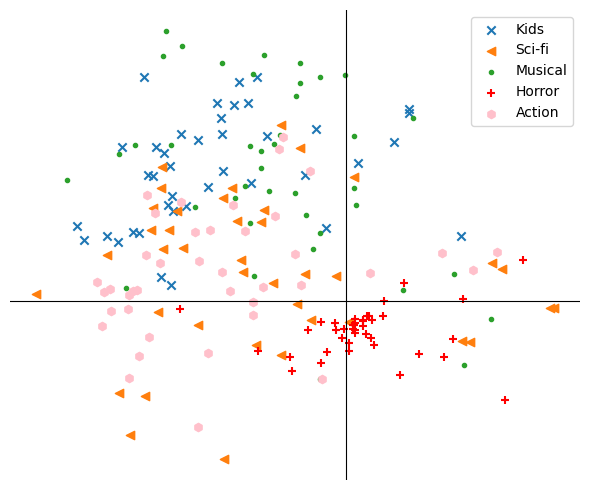

In [21]:
kid_indices = []
horror_indices = []
scifi_indices = []
action_indices = []
musical_indices = []
for i, movie in enumerate(movie_2_data):
    if genres.index('Children') in movie[1]:
        kid_indices.append(i)
    elif genres.index('Sci-Fi') in movie[1]:
        scifi_indices.append(i)
    elif genres.index('Horror') in movie[1]:
        horror_indices.append(i)
    elif genres.index('Action') in movie[1]:
        action_indices.append(i)
    elif genres.index('Musical') in movie[1]:
        musical_indices.append(i)
        
kid_vect = V2[:, kid_indices[:40]]
horror_vect = V2[:, horror_indices[:40]]
scifi_vect = V2[:, scifi_indices[:40]]
action_vect = V2[:, action_indices[:40]]
musical_vect = V2[:, musical_indices[:40]]

fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.axhline(0, color='black', lw=0.8)
ax.axvline(0, color='black', lw=0.8)

ax.scatter(kid_vect[0], kid_vect[1], label='Kids', marker='x')
ax.scatter(scifi_vect[0], scifi_vect[1], label='Sci-fi', marker='<')
ax.scatter(musical_vect[0], musical_vect[1], label='Musical', marker='.')
ax.scatter(horror_vect[0], horror_vect[1], label='Horror', marker='+', color='red')
ax.scatter(action_vect[0], action_vect[1], label='Action', marker='h', color='pink', alpha=1)

ax.legend()
ax.axis('off')
plt.tight_layout()
plt.savefig('movie_embeddings.pdf')
plt.show()

#### Plotting the embedding of a specific user, the embeddings of the movies he has rated 5 stars (he likes) and the movies he has rated 0.5 (he does not like)

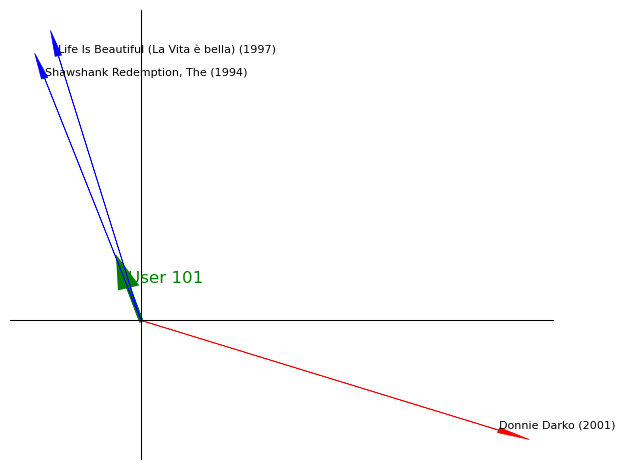

In [62]:
n_user = 100 # ID of the user (according to our indexation)
fav_mov_inds = [t[0] for t in user_2_data[n_user] if t[1]==5]
worst_mov_inds = [t[0] for t in user_2_data[n_user] if t[1]==0.5]

# Needed to plot the user 1 embbeding vector
vector_user = [[0,0,U2[0,0],U2[1,0], f'User {id_2_user[0]}']]

plt.arrow(0, 0, U2[0,n_user], U2[1,n_user], head_width=0.05, head_length=0.1, fc='green', ec='green', lw=3)
plt.text(U2[0,n_user], U2[1,n_user], f'User {id_2_user[n_user]}', fontsize=12, color='green', ha='left', va='bottom')


# Needed to plot the embbeding vectors of the movies he has rated 5 stars
v = V2[:,fav_mov_inds]
vectors = [[0, 0, v[0,i], v[1,i], df.loc[df['movieId']== id_2_movie_genres[fav_mov_inds[i]][0], 'title'].iloc[0]] for i in range(len(fav_mov_inds))]
# Plot each vector and label
for vector in vectors:
    x_origin, y_origin, x_direction, y_direction, label = vector
    plt.arrow(float(x_origin), float(y_origin), float(x_direction), float(y_direction),
              head_width=0.02, head_length=0.1, fc='blue', ec='blue', lw=0.5)
    plt.text(float(x_origin) + float(x_direction), float(y_origin) + float(y_direction), label, fontsize=8, ha='left', va='bottom')


# Needed to plot the embbeding vectors of the movies he has rated 0.5 stars
v2 = V2[:,worst_mov_inds]
vectors2 = [[0, 0, v2[0,i], v2[1,i], df.loc[df['movieId']== id_2_movie_genres[worst_mov_inds[i]][0], 'title'].iloc[0]] for i in range(len(worst_mov_inds))]

# Plot each vector and label
for vector in vectors2:
    x_origin, y_origin, x_direction, y_direction, label = vector
    plt.arrow(float(x_origin), float(y_origin), float(x_direction), float(y_direction),
              head_width=0.02, head_length=0.1, fc='red', ec='red', lw=0.5)
    plt.text(float(x_origin) + float(x_direction), float(y_origin) + float(y_direction), label, fontsize=8, ha='left', va='bottom')

plt.axhline(0, color='black', lw=0.75)
plt.axvline(0, color='black', lw=0.75)
# Remove x and y axes along with labels and numbers
plt.axis('off')

# Show plot
plt.tight_layout()
plt.savefig('A_user_preferences.pdf')
plt.show()